In [1]:
from __future__ import division
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import pyproximal

In [2]:
D = lambda x : np.c_['2,3',np.r_[np.diff(x,1,0), np.zeros([1,x.shape[1]])],np.c_[np.diff(x,1,1), np.zeros([x.shape[0],1])]]
Dadj = lambda v : np.r_['0,2',-v[0,:,0],-np.diff(v[:-1,:,0],1,0),v[-2,:,0]] + np.c_['1,2',-v[:,0,1],-np.diff(v[:,:-1,1],1,1),v[:,-2,1]]

In [3]:
def prox_f_conj (u, Lambda) :
    return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2))

In [4]:
def prox_g1_conj (u, Lambda) :
    return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2))

def proximal_L12_operator(u,gamma,Lambda) : 
    return( (u - gamma*prox_g1_conj(u/gamma,Lambda)))

def proximal_operator_lasso(u, alpha,gamma):
    L1 = pyproximal.L1(sigma=alpha)
    prox_result = L1.prox(u,gamma).reshape(u.shape)
    return prox_result

def complete_proximal_operator(u, x, gamma, Lambda, alpha):
    redef_u = u + gamma * D(x)
    prox_lasso = proximal_operator_lasso(redef_u/gamma, alpha, 1/gamma)
    prox_tv = proximal_L12_operator(prox_lasso, 1/gamma, Lambda)
    proximal_composition = gamma * prox_tv
    return redef_u - proximal_composition

In [5]:
def original_chambolle_algorithm(noised_image,Lambda,gamma,nbiter) :
    
    (N1,N2) = noised_image.shape
    u = np.zeros([N1,N2,2])
    x = np.zeros([N1,N2,2])

    Ep_array = np.zeros(nbiter) 
    Ed_array = np.zeros(nbiter) 

    sqnormy = np.linalg.norm(noised_image)**2/2

    for iter in range(nbiter):  

        x = -Dadj(u) + noised_image
        u = prox_f_conj(u+gamma*D(x),Lambda)
        Ep_array[iter] = np.linalg.norm(x-noised_image)**2/2 + Lambda*np.sum(np.sqrt(np.sum(D(x)**2,2))) 
        Ed_array[iter] = np.linalg.norm(noised_image-Dadj(u))**2/2 - sqnormy
    
    #Last x obtained is the denoised version of noised_image, we return it
    xdenoised = x
    return xdenoised,Ep_array,Ed_array

In [6]:
def chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter) :
    
    (N1,N2) = noised_image.shape
    u = np.zeros([N1,N2,2])
    x = np.zeros([N1,N2,2])

    Ep_array = np.zeros(nbiter) 
    Ed_array = np.zeros(nbiter)

    sqnormy = np.linalg.norm(noised_image)**2/2

    for iter in range(nbiter):  

        x = -Dadj(u) + noised_image
        u = complete_proximal_operator(u,x,gamma,Lambda,alpha)
        Ep_array[iter] = np.linalg.norm(x-noised_image)**2/2 + Lambda*np.sum(np.sqrt(np.sum(D(x)**2,2))) 
        Ed_array[iter] = np.linalg.norm(noised_image-Dadj(u))**2/2 - sqnormy

    xdenoised = x
    return xdenoised,Ep_array,Ed_array

C:\Users\96176\AppData\Local\Temp\ipykernel_67676\576602871.py:13: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  xsharp = misc.ascent()


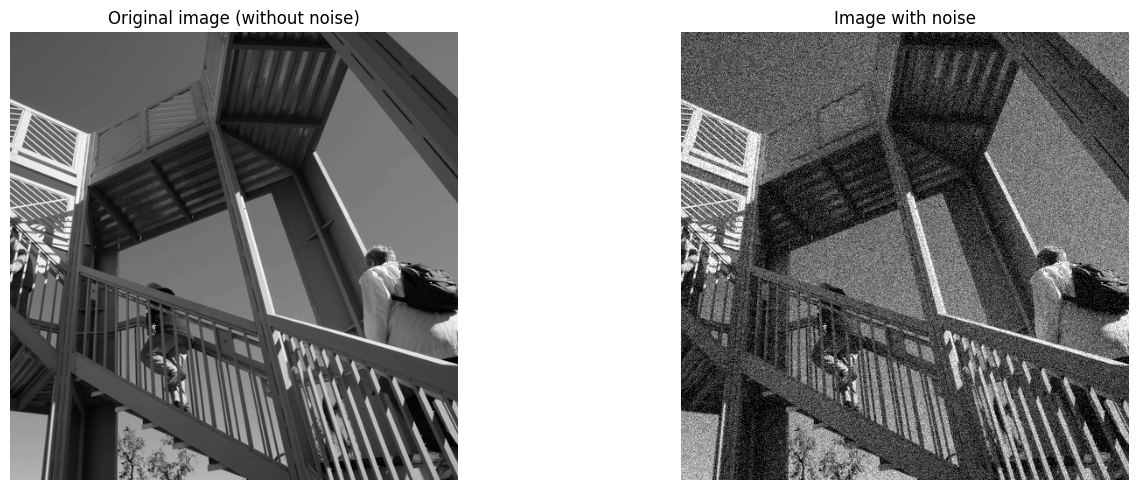

In [7]:
import random 
import cv2 
  
def add_noise(img, noise_level, stripe_width=1):
    noisy_img = np.copy(img)
    gaussian_noise = np.random.normal(0, 25, img.shape)
    noisy_img = noisy_img + gaussian_noise
    noisy_img = np.clip(noisy_img, 0, 255)
    noisy_img = noisy_img.astype(np.uint8)
    return noisy_img
  
'''Generating input :'''
xsharp = misc.ascent()
xsharp = xsharp.astype(np.float32) #create image
'''Add Noise'''
(N1,N2) = np.shape(xsharp)
noised_image = add_noise(xsharp,4000)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

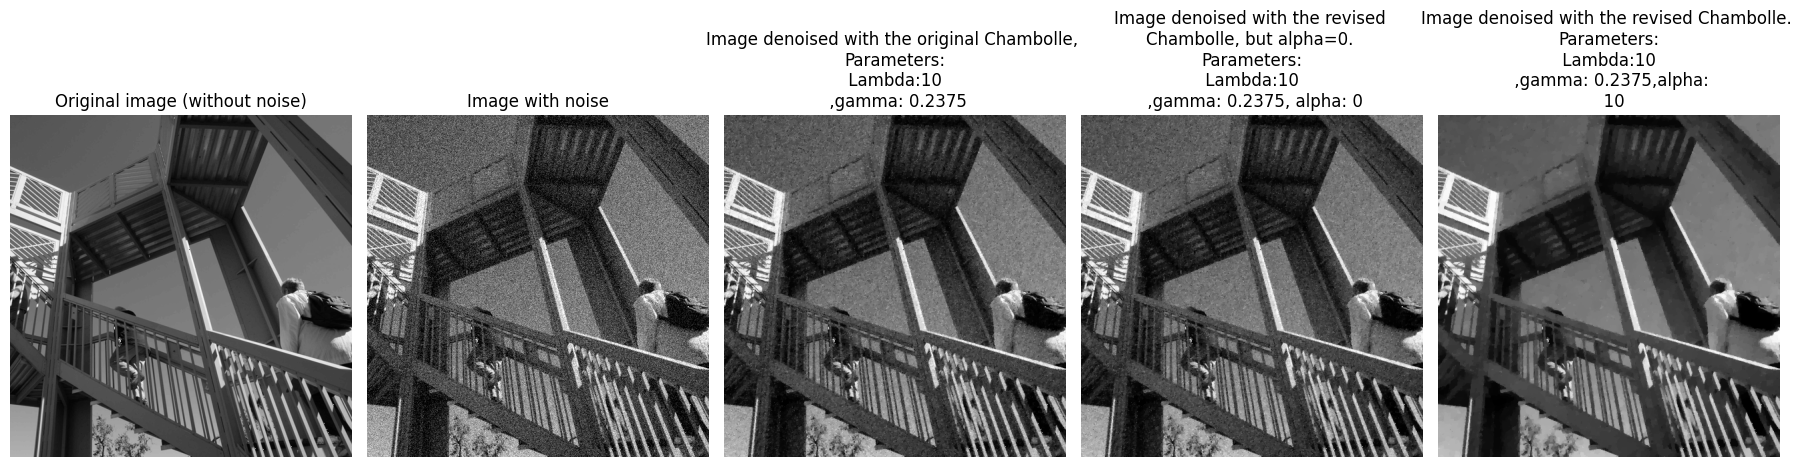

In [8]:
Lambda = 10
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400
alpha = 10

original_denoised_image,original_ep_array,original_ed_array  = original_chambolle_algorithm(noised_image,Lambda,gamma,nbiter)
denoised_image_nolasso,alphazero_ep_array,alphazero_ed_array  = chambolle_algorithm(noised_image,Lambda,gamma,0,nbiter)
denoised_image_lasso,alpha_ep_array,alpha_ed_array = chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter)


fig, axs = plt.subplots(1, 5, figsize=(18, 5))
axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')
axs[2].imshow(original_denoised_image, cmap='gray')
axs[2].set_title(f"Image denoised with the original Chambolle, \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}")
axs[3].imshow(denoised_image_nolasso, cmap='gray')
axs[3].set_title(f"Image denoised with the revised \nChambolle, but alpha=0. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}, alpha: {0}")
axs[4].imshow(denoised_image_lasso, cmap='gray')
axs[4].set_title(f"Image denoised with the revised Chambolle. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma},alpha:\n  {alpha}")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [9]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(img1, img2, max_value=255):
    img1 = np.asarray(img1, dtype=np.float32)
    img2 = np.asarray(img2, dtype=np.float32)
    
    if img1.shape != img2.shape:
        raise ValueError(f"Input images must have the same dimensions: img1.shape = {img1.shape}, img2.shape = {img2.shape}")
    
    ssim_value = ssim(img1, img2, data_range=max_value)
    return ssim_value

noisy_image_ssim = calculate_ssim(xsharp, noised_image)
original_chambolle_ssim = calculate_ssim(xsharp, original_denoised_image)
alphazero_ssim = calculate_ssim(xsharp, denoised_image_nolasso)
alpha_ssim = calculate_ssim(xsharp, denoised_image_lasso)
print("SSIM of the noisy image:", noisy_image_ssim)
print("SSIM for original Chambolle:", original_chambolle_ssim)
print("SSIM for revised version with alpha = 0 :", alphazero_ssim)
print("SSIM of the image denoised with the revised Chambolle and alpha = 10:", alpha_ssim)

SSIM of the noisy image: 0.37957191675439333
SSIM for original Chambolle: 0.6362604978854819
SSIM for revised version with alpha = 0 : 0.6362604978854819
SSIM of the image denoised with the revised Chambolle and alpha = 10: 0.8442234968008143


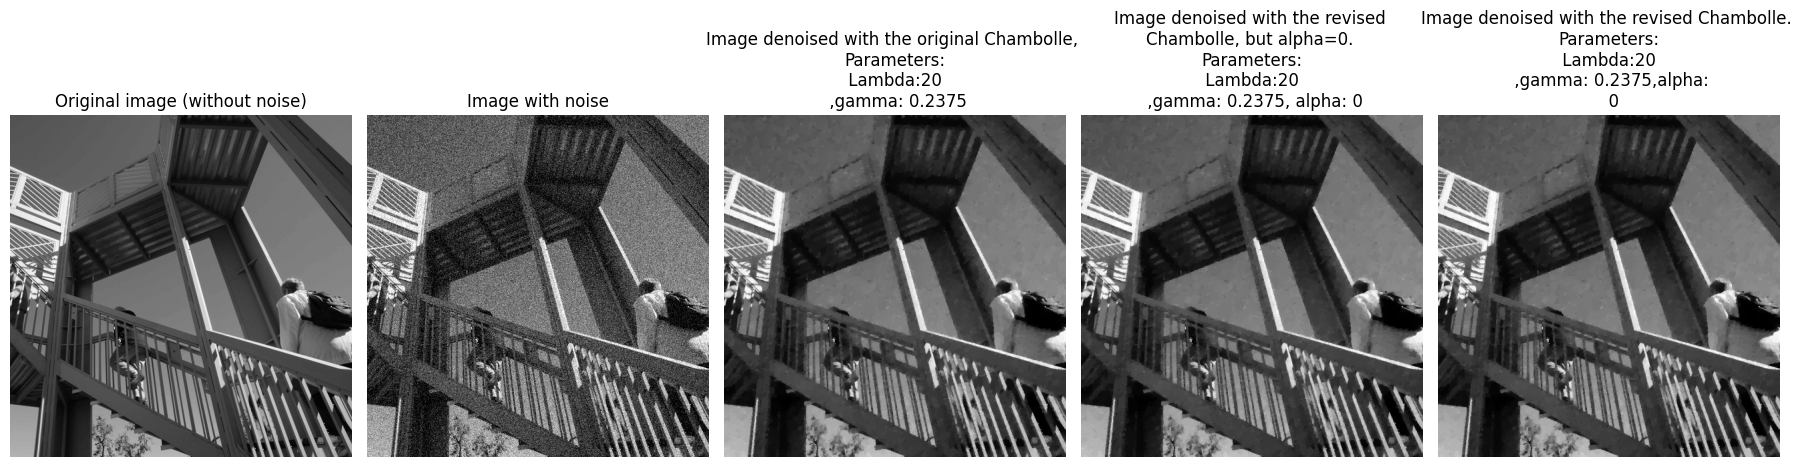

In [10]:
Lambda = 20
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400
alpha = 0

original_denoised_image,original_ep_array,original_ed_array  = original_chambolle_algorithm(noised_image,Lambda,gamma,nbiter)
denoised_image_nolasso,alphazero_ep_array,alphazero_ed_array  = chambolle_algorithm(noised_image,Lambda,gamma,0,nbiter)
denoised_image_lasso,alpha_ep_array,alpha_ed_array = chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter)


fig, axs = plt.subplots(1, 5, figsize=(18, 5))
axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image (without noise)')
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with noise')
axs[2].imshow(original_denoised_image, cmap='gray')
axs[2].set_title(f"Image denoised with the original Chambolle, \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}")
axs[3].imshow(denoised_image_nolasso, cmap='gray')
axs[3].set_title(f"Image denoised with the revised \nChambolle, but alpha=0. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma}, alpha: {0}")
axs[4].imshow(denoised_image_lasso, cmap='gray')
axs[4].set_title(f"Image denoised with the revised Chambolle. \nParameters:\n Lambda:{Lambda} \n ,gamma: {gamma},alpha:\n  {alpha}")
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [12]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(img1, img2, max_value=255):
    img1 = np.asarray(img1, dtype=np.float32)
    img2 = np.asarray(img2, dtype=np.float32)
    
    if img1.shape != img2.shape:
        raise ValueError(f"Input images must have the same dimensions: img1.shape = {img1.shape}, img2.shape = {img2.shape}")
    
    ssim_value = ssim(img1, img2, data_range=max_value)
    return ssim_value

noisy_image_ssim = calculate_ssim(xsharp, noised_image)
original_chambolle_ssim = calculate_ssim(xsharp, original_denoised_image)
alphazero_ssim = calculate_ssim(xsharp, denoised_image_nolasso)
alpha_ssim = calculate_ssim(xsharp, denoised_image_lasso)
print("SSIM of the noisy image:", noisy_image_ssim)
print("SSIM for original Chambolle:", original_chambolle_ssim)
print("SSIM for revised version with alpha = 0 :", alphazero_ssim)
print("SSIM of the image denoised with the revised Chambolle and alpha = 10:", alpha_ssim)

SSIM of the noisy image: 0.37957191675439333
SSIM for original Chambolle: 0.8401277555392352
SSIM for revised version with alpha = 0 : 0.8401277555392352
SSIM of the image denoised with the revised Chambolle and alpha = 10: 0.8401277555392352
